# ALUMNO: Ezequiel Scordamaglia

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [2]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pipeline NLP transformers
# ADVERTENCIA: la instalación de SpaCy puede demorar más de 10 minutos!
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

  error: subprocess-exited-with-error
  
  × Building wheel for spacy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1331 lines of output]
      Copied C:\Users\EZEQUIEL\AppData\Local\Temp\pip-install-mww3qviq\spacy_a3bb880896a345288e0c741941c513c1\setup.cfg -> C:\Users\EZEQUIEL\AppData\Local\Temp\pip-install-mww3qviq\spacy_a3bb880896a345288e0c741941c513c1\spacy\tests\package
      Copied C:\Users\EZEQUIEL\AppData\Local\Temp\pip-install-mww3qviq\spacy_a3bb880896a345288e0c741941c513c1\pyproject.toml -> C:\Users\EZEQUIEL\AppData\Local\Temp\pip-install-mww3qviq\spacy_a3bb880896a345288e0c741941c513c1\spacy\tests\package
      Cythonizing sources
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\spacy
      copying spacy\about.py -> build\lib.win-amd64-cpython-310\spacy
      copying spacy\compat.py -> build\lib.win-amd64-cpython-310\spacy

In [1]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [2]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2023-09-04 19:29:54 INFO: Downloading default packages for language: es (Spanish)...
2023-09-04 19:29:56 INFO: File exists: C:\Users\EZEQUIEL\stanza_resources\es\default.zip.
2023-09-04 19:29:59 INFO: Finished downloading models and saved to C:\Users\EZEQUIEL\stanza_resources.
2023-09-04 19:30:00 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2023-09-04 19:30:00 INFO: Use device: cpu
2023-09-04 19:30:00 INFO: Loading: tokenize
2023-09-04 19:30:00 INFO: Loading: mwt
2023-09-04 19:30:00 INFO: Loading: pos
2023-09-04 19:30:00 INFO: Loading: lemma
2023-09-04 19:30:00 INFO: Loading: depparse
2023-09-04 19:30:00 INFO: Loading: ner
2023-09-04 19:30:01 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [3]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [4]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los murcielagos'

In [5]:
# Ejemplo de como funciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokens = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokens)
print("Lematización de cada token:")
for token in tokens:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[murcielagos, 'murcielago']


### 3 - Diccionario de entrada

In [19]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?", "¿Cómo te llamás?"],
              "responses": ["Mi nombre es BancoBot", "Yo soy BancoBot"]
             },
            {"tag": "contacto",
              "patterns": ["¿Cómo me contacto con un asesor?", "¿A que número debo llamar?", "¿Cuál es el número de teléfono del banco?", "¿Me puedo contactar por whatsapp"],
              "responses": ["Podes contactarnos al siguiente número XXXX-XXXX en el horario de 10 a 20Hs", "Podes contactarnos por whatsapp al XX-XXXX-XXXX"]
             },
            {"tag": "tarjetas",
              "patterns": ["Quiero solicitar una tarjeta", "Quiero solicitar una tarjeta de crédito"],
              "responses": ["Para solicitar una tarjeta de crédito debes ingresar a nuestra web y dirigirte a la seccion de 'Tarjetas' > 'Solicitar tarjeta'. Allí deberás completar el formulario y un asesor se contactará con usted para continuar con el proceso.", 
                            "Puedes solicitar la tarjeta de crédito desde la app o desde el homebanking. Para ello debes dirigirte a la seccion de 'Tarjetas' > 'Solicitar tarjeta' y completar el formulario. Un asesor se contactará con usted para continuar con el proceso."]
             },
            {"tag": "claves",
              "patterns": ["Perdí mi clave del cajero", "Perdi mi clave del HomeBanking", "¿Como reinicio mi clave?", "¿Como recupero mi clave?", "Se me bloqueo el usuario"],
              "responses": ["Para generar una nueva clave del HomeBanking o del cajero automático debes dirigirte a un cajero automático y generar una nueva clave en la seccion de 'Claves' > 'Claves de acceso'"]
             },
            {"tag": "productos",
              "patterns": ["Quiero solicitar un nuevo producto", "¿Cómo doy de alta un producto?"],
              "responses": ["Para dar de alta un producto debes ingresar a nuestra web y dirigirte a la seccion de 'Productos' > 'Alta de producto'. Un asesor se contactará con usted para continuar con el proceso.", 
                            "Puedes dar de alta un producto desde la app o desde el homebanking. Para ello debes dirigirte a la seccion de 'Productos' > 'Alta de producto' y completar el formulario. Un asesor se contactará con usted para continuar con el proceso."]
             },
            {"tag": "seguros",
              "patterns": ["Quiero un seguro", "Quiero asegurar mi casa", "Quiero asegurar mi auto", "Quiero asegurar mi moto", "Quiero asegurar mi celular"],
              "responses": ["Para solicitar un seguro, puedes entrar a nuestra web y dirigirte a la seccion de 'Seguros' > 'Solicitar seguro'. Ahi podrás simular las coberturas de tu seguro y cuando estes listo puedes enviar la solicitud de alta.", 
                            "Puedes dar de alta un seguro desde la app o desde el homebanking. Para ello debes dirigirte a la seccion de 'Seguros' > 'Solicitar seguro' y completar el formulario. Un asesor se contactará con usted para continuar con el proceso."]
             },
            {"tag": "inversiones",
              "patterns": [ "Quiero realizar una inversion", "Quiero invertir en fondos", "Quiero realizar un plazo fijo"],
              "responses": ["Se puede realizar inversiones tanto desde el homebanking como desde la app. Para realizar una inversión debes dirigirte a la seccion de 'Inversiones' > 'Invertir' y seleccionar el tipo de inversión que deseas realizar."]
             },
              {"tag": "acciones",
              "patterns": [ "Quiero invertir en acciones", "Quiero invertir en un fondo de acciones"],
              "responses": ["Las acciones o fondos de inversion basados en acciones son un tipo de inversión con rentabilidad variable y alto riego. Para realizar una inversión en acciones debes dirigirte a la seccion de 'Inversiones' > 'Invertir' y seleccionar el tipo de inversión que deseas realizar.", 
                            "Si deseas invertir en acciones debes dirigirte a la seccion de 'Inversiones' > 'Invertir' y seleccionar el tipo de inversión que deseas realizar."]
             },
             {"tag": "despedida",
              "patterns": [ "Adiós", "Chau", "Hasta luego", "Nos vemos"],
              "responses": ["Hasta luego!", "Cualquier otra consulta estoy a tu disposición"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [20]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocabulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\spacy\language.py:1030: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\spacy\language.py:1030: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['cual', 'es', 'el', 'numero', 'de', 'telefono', 'de', 'el', 'banco']
Entities: []
  doc = self._ensure_doc(text)
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\spacy\language.py:1030: U

In [21]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'acción', 'adios', 'alta', 'asegurar', 'asesor', 'auto', 'banco', 'bloqueo', 'cajero', 'casa', 'celular', 'chau', 'clave', 'como', 'con', 'contactar', 'contacto', 'credito', 'cual', 'dar', 'de', 'deber', 'e', 'el', 'en', 'este', 'fijo', 'fondo', 'hasta', 'holar', 'homebanking', 'inversion', 'invertir', 'llama', 'llamar', 'luego', 'mi', 'moto', 'nombre', 'nuevo', 'numerar', 'numero', 'perder', 'plazo', 'poder', 'por', 'producto', 'que', 'querer', 'quien', 'realizar', 'recuperar', 'reinicio', 'seguro', 'ser', 'solicitar', 'tal', 'tarjeta', 'telefono', 'tu', 'tú', 'uno', 'usuario', 'ver', 'whatsapp', 'yo', 'él']
classes: ['acciones', 'bienvenida', 'claves', 'contacto', 'despedida', 'inversiones', 'nombre', 'productos', 'seguros', 'tarjetas']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', '¿Cómo te llamás?', '¿Cómo me contacto con un asesor?', '¿A que número debo llamar?', '¿Cuál es el número de teléfono del banco?', '¿Me puedo contactar por

In [22]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 68


In [23]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 10


In [24]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding
from sklearn.feature_extraction.text import TfidfVectorizer
import urllib.request

# Tomar las spanish_stopwords de la URL https://github.com/Alir3z4/stop-words/blob/master/spanish.txt
spanish_stopwords = urllib.request.urlopen('https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt')
# Convertir a lista
spanish_stopwords = [line.decode("utf-8").strip() for line in spanish_stopwords.readlines()]

word_vectorizer = TfidfVectorizer(vocabulary=words, stop_words=spanish_stopwords)

# Imprimir titulos de words
print(words)

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):

    # print("doc:", doc)

    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))

    # print("tokens:", tokens)

    for token in tokens:
        text.append(token.lemma_)
    
    # print(text)

    # Vectorizar con TFIDF
    text_vectorized = word_vectorizer.fit_transform([" ".join(text)])

    # Convertir el vector TF-IDF en una lista plana
    text_vectorized = text_vectorized.toarray().flatten().tolist()

    # # # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    # bow = []
    # for word in words:
    #     bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", text_vectorized, "y:", output_row)
    training.append([text_vectorized, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

['a', 'acción', 'adios', 'alta', 'asegurar', 'asesor', 'auto', 'banco', 'bloqueo', 'cajero', 'casa', 'celular', 'chau', 'clave', 'como', 'con', 'contactar', 'contacto', 'credito', 'cual', 'dar', 'de', 'deber', 'e', 'el', 'en', 'este', 'fijo', 'fondo', 'hasta', 'holar', 'homebanking', 'inversion', 'invertir', 'llama', 'llamar', 'luego', 'mi', 'moto', 'nombre', 'nuevo', 'numerar', 'numero', 'perder', 'plazo', 'poder', 'por', 'producto', 'que', 'querer', 'quien', 'realizar', 'recuperar', 'reinicio', 'seguro', 'ser', 'solicitar', 'tal', 'tarjeta', 'telefono', 'tu', 'tú', 'uno', 'usuario', 'ver', 'whatsapp', 'yo', 'él']
X: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

### 5 - Entrenamiento del modelo

In [25]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (68,) output: 10


In [26]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               8832      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 17738 (69.29 KB)
Trainable params: 17738 (69.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [27]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 5ms/step - loss: 2.2994 - accuracy: 0.1212
Epoch 2/200
2/2 [==============================] - 0s 5ms/step - loss: 2.2626 - accuracy: 0.1818
Epoch 3/200
2/2 [==============================] - 0s 4ms/step - loss: 2.2976 - accuracy: 0.1212
Epoch 4/200
2/2 [==============================] - 0s 5ms/step - loss: 2.2598 - accuracy: 0.0606
Epoch 5/200
2/2 [==============================] - 0s 4ms/step - loss: 2.2466 - accuracy: 0.0909
Epoch 6/200
2/2 [==============================] - 0s 9ms/step - loss: 2.2542 - accuracy: 0.2121
Epoch 7/200
2/2 [==============================] - 0s 5ms/step - loss: 2.2462 - accuracy: 0.1818
Epoch 8/200
2/2 [==============================] - 0s 6ms/step - loss: 2.2338 - accuracy: 0.1212
Epoch 9/200
2/2 [==============================] - 0s 6ms/step - loss: 2.2013 - accuracy: 0.2727
Epoch 10/200
2/2 [==============================] - 0s 5ms/step - loss: 2.2732 - accuracy: 0.0303
Epoch 11/200
2/2 [===========

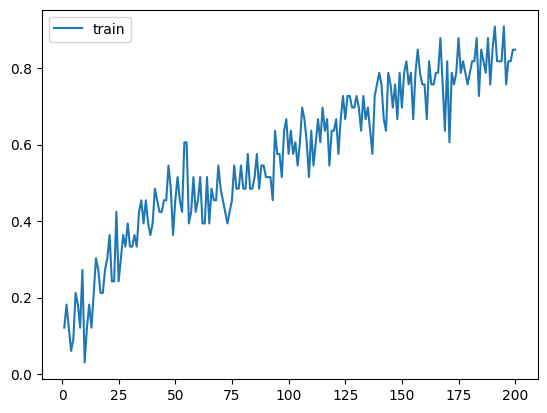

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [29]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# En NLP además de los modelos es necesario proveer: tokenizador y vocabulario.
# La tríada modelo+tokenizador+vocabulario es necesaria para hacer inferencia. 
# Sin una de las tres no se puede hacer inferencia.

# en este caso guardamos:
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('models/words.pkl','wb'))
pickle.dump(classes, open('models/classes.pkl','wb'))
model.save('models/chatbot_model.h5')

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 6 - Testing y validación

In [30]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [31]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Q: Cual es el numero de telefono del banco?
1/1 [==============================] - 0s 122ms/step


d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\spacy\language.py:1030: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\spacy\language.py:1030: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['cual', 'es', 'el', 'numero', 'de', 'telefono', 'de', 'el', 'banco']
Entities: []
  doc = self._ensure_doc(text)


BOT: Podes contactarnos al siguiente número XXXX-XXXX en el horario de 10 a 20Hs
Q: Se me bloqueo el usuario del homebanking
1/1 [==============================] - 0s 77ms/step


d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\spacy\language.py:1030: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['se', 'e', 'me', 'bloqueo', 'el', 'usuario', 'de', 'el', 'homebanking']
Entities: []
  doc = self._ensure_doc(text)


BOT: Para generar una nueva clave del HomeBanking o del cajero automático debes dirigirte a un cajero automático y generar una nueva clave en la seccion de 'Claves' > 'Claves de acceso'
Q: Como solicito un nuevo producto?
1/1 [==============================] - 0s 82ms/step
BOT: Puedes dar de alta un producto desde la app o desde el homebanking. Para ello debes dirigirte a la seccion de 'Productos' > 'Alta de producto' y completar el formulario. Un asesor se contactará con usted para continuar con el proceso.
Q: Quiero realizar una inversion en acciones
1/1 [==============================] - 0s 83ms/step
BOT: Se puede realizar inversiones tanto desde el homebanking como desde la app. Para realizar una inversión debes dirigirte a la seccion de 'Inversiones' > 'Invertir' y seleccionar el tipo de inversión que deseas realizar.
Q: Puedo invertir en acciones?
1/1 [==============================] - 0s 82ms/step
BOT: Las acciones o fondos de inversion basados en acciones son un tipo de inversi

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\spacy\language.py:1030: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['cual', 'es', 'la', 'cotizacion', 'de', 'el', 'dolar', 'oficial']
Entities: []
  doc = self._ensure_doc(text)


BOT: Podes contactarnos por whatsapp al XX-XXXX-XXXX
Q: Juega futbol?
BOT: Perdón, no comprendo la pregunta.
Q: Adios
1/1 [==============================] - 0s 56ms/step
BOT: Hasta luego!
Q: 
BOT: Perdón, no comprendo la pregunta.
Q: 
BOT: Perdón, no comprendo la pregunta.


KeyboardInterrupt: Interrupted by user

# ACLARACIONES
Se utilizan stop_words en español, tomadas del siguiente repositorio: https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt

Se modifica la vectorizacion para usar TF-IDF en vez de Bag of words

Se cambia el diccionario de entrada para convertirlo en un Bot bancario.

# CONCLUSIONES
En comparación con el primer bot que utiliza NLTK, este bot parece funcionar un poco mejor, ya que se comparan las entradas del usuario con algunos tokens esperados en vez de compararlo directamente con el documento a devolver, lo cual disminuye un poco los errores en las respuestas. 
A su vez, tiene un problema similar al modelo de NLTK, ya que si se ingresa una frase que no tenga nada que ver con el contexto, pero coincide algun término con los terminos de los tokens, devuelve un documento que no se corresponde con lo consultado por el usuario. 
Por ejemplo en el caso en el que se consulta "Cual es la cotizacion del dolar oficial?" se responde con "Podes contactarnos por whatsapp al XX-XXXX-XXXX". Esto sucede porque uno de los tokens de la categoria "contacto" era "¿Cuál es el número de teléfono del banco?" y algunos terminos de la consulta el usuario aparecían ahi.
De todas formas el modelo sirve para responder cierta información pre cargada y contestar al usuario consultas frecuentes que puedan descongestionar la atención de los asesores de un banco, en este caso.
